In [ ]:
%%capture
! [ -e /content ] && pip install -Uqq fastbook
import fastbook
fastbook.setup_book()

from fastai.vision.all import *
from fastbook import *

In [ ]:
from sklearn.model_selection import StratifiedKFold

def train_valid_split(x, y, df, n_splits=5, seed=None, shuffle=True):
    # create splitter.
  splitter = StratifiedKFold(n_splits=n_splits, random_state=seed, shuffle=shuffle)
  
  trainings = []
  validations = []

    # for each fold, grab a list of the ID's for training and validation.
  for train_idx, valid_idx in splitter.split(x,y):

    train_ids = df['external_id'][train_idx].to_list()
    trainings.append(train_ids)

    valid_ids = df['external_id'][valid_idx].to_list()
    validations.append(valid_ids)

  return trainings, validations



  # helper function to calculate the median likelihood of malignancy.
def calc_median_likelihood(birads_score):
    birads_score = birads_score.lower()
    likelihood_of_malignancy = {
        '3':(0,2),
        '4_a':(2,10),
        '4_b':(10,50),
        '4_c':(50,95),
        '5':(95,100)}

    if birads_score == '2':
      return 0
    else:
      return np.median(np.linspace(likelihood_of_malignancy[birads_score][0],
                                    likelihood_of_malignancy[birads_score][1],
                                    likelihood_of_malignancy[birads_score][1]-likelihood_of_malignancy[birads_score][0]))/100

In [ ]:
# set number of splits for cv training.
k=5
write_output = False

  # specify features to keep from annotations file.
features_of_interest = ['external_id','pathology','predicted_birads','shape_acr','orientation','marginal_zone_acr','echo_pattern_acr','posterior_features_acr']

df = pd.read_csv('/content/gdrive/MyDrive/BUS Project Home/Datasets/Mayo/mayo_dataset/annotations_histology.csv')[features_of_interest]

  # set "elevated risk" to "benign".
df['pathology'] = np.where(df['pathology']=='Elevated Risk','Benign',df['pathology'])

  # remove unknown pathologies, and missing birads scores.
df = df[df['pathology']!='Unknown']
df = df[df['predicted_birads'].notna()]

  # calculate median likelihood of malignancy based on ranges - do not convert to decimal.
df['median_likelihood_of_malignancy'] = df['predicted_birads'].apply(lambda x: calc_median_likelihood(x))

  # get a list of all pre-cropped image files.
image_urls = get_image_files('/content/gdrive/MyDrive/BUS Project Home/Share_with_group/Jeff_Baggett/bus_data/first_mayo_fastai/images').items

  # for each id (x), find all urls associated with that id and affix it to the dataframe as a list of values.
df['image_url'] = df['external_id'].apply(lambda x: [url for url in image_urls if str(x) in str(url)])

  # remove rows where no image file was found.
df = df[df['image_url'].notna()].reset_index().drop(columns='index')

  # if there is one or more url's listed in the column, then mark it as a multi-image patient id.
df['has_multiple_images'] = df['image_url'].apply(lambda x: False if len(x)<2 else True)

  # create a stratified sample based on if a patient had multiple ids.
trainings, validations = train_valid_split(x=np.zeros(len(df)), 
                                           y=df['has_multiple_images'],
                                           df=df,
                                           n_splits=k, 
                                           seed=516)

  # expand the dataframe where id had multiple images from previous step.
df = df.explode('image_url').reset_index().drop(columns='index')

  # remove rows where no image file was found. Remove the index and multiple images columns since we no longer need that tag.
df = df[df['image_url'].notna()].reset_index().drop(columns=['index','has_multiple_images'])

  # set the fold in which the image belongs in the validation set. Each new column will be referenced during cross-validation training.
for i, valid_ids in enumerate(validations):
    df[f'fold{i}_is_valid'] = df['external_id'].apply(lambda x: 1 if x in valid_ids else 0)

  # write output if true.
if write_output:
    df.to_csv('/content/gdrive/MyDrive/BUS Project Home/Share_with_group/Josh_Jarvey/biradsnet labels/annotations_biradsnet2.csv',index=False)

df.head()

,external_id,pathology,predicted_birads,shape_acr,orientation,marginal_zone_acr,echo_pattern_acr,posterior_features_acr,median_likelihood_of_malignancy,image_url,fold0_is_valid,fold1_is_valid,fold2_is_valid,fold3_is_valid,fold4_is_valid
0,107342448,Malignant,5,irregular,parallel,angular,hypoechoic,shadowing,0.975,/content/gdrive/MyDrive/BUS Project Home/Share_with_group/Jeff_Baggett/bus_data/first_mayo_fastai/images/107342448_malignant_long.png,0,0,1,0,0
1,113014078,Benign,4_c,irregular,parallel,circumscribed_,hypoechoic,shadowing,0.725,/content/gdrive/MyDrive/BUS Project Home/Share_with_group/Jeff_Baggett/bus_data/first_mayo_fastai/images/113014078_benign_long.png,0,0,0,1,0
2,121599602,Benign,4_a,oval,parallel,circumscribed_,hypoechoic,none,0.060,/content/gdrive/MyDrive/BUS Project Home/Share_with_group/Jeff_Baggett/bus_data/first_mayo_fastai/images/121599602_benign_long.png,0,1,0,0,0
3,126590425,Malignant,5,irregular,not_parallel,angular,hypoechoic,shadowing,0.975,/content/gdrive/MyDrive/BUS Project Home/Share_with_group/Jeff_Baggett/bus_data/first_mayo_fastai/images/126590425_malignant_tran.png,0,0,0,0,1
4,128996168,Malignant,5,irregular,not_parallel,microlobulated,hypoechoic,shadowing,0.975,/content/gdrive/MyDrive/BUS Project Home/Share_with_group/Jeff_Baggett/bus_data/first_mayo_fastai/images/128996168_malignant_tran.png,0,1,0,0,0


In [ ]:
#@title
#   # checking each fold to ensure no overlap in id numbers between train and valid. Also check how pathology was distributed.
# for i in range(k):
#     t = df[df[f'fold{i}_is_valid']==0].external_id.to_list()
#     v = df[df[f'fold{i}_is_valid']==1].external_id.to_list()

#     print(f"Fold {i}:")

#     if any(id in t for id in v):
#       print("there is overlap between train and valid")
#       print(sorted(list(set(v).intersection(t))))
#     else:
#       print("no overlap between train and valid")

#     print("train len: ",len(t))
#     print("valid len: ",len(v))

#     print(df[df[f'fold{i}_is_valid']==1].pathology.value_counts())
#     print("\n")

In [ ]:
from torch.distributions.beta import Beta

class MultiMixHandler(Callback):
    "A handler class for implementing `MixUp` style scheduling"
    run_valid = False
    def __init__(self,
        alpha:float=0.4 # Determine `Beta` distribution in range (0.,inf]
    ):
        self.distrib = Beta(tensor(alpha), tensor(alpha))

    def before_train(self):
        self.learn.loss_func.mixup = True # turn on mixup for training.
    
    def before_batch(self):
        "Blend xb with another random item in a second batch xb1,yb1 with `lam` weights"
        if isinstance(self.y,tuple):  # MAIN CHANGE IS THIS TO HANDLE THAT y is a tuple
            bs = self.y[0].size(0)
        else:
            bs = self.y.size(0)
        lam = self.distrib.sample((bs,)).squeeze().to(self.x.device)
        # lam = torch.stack([lam, 1-lam], 1)
        # self.lam = lam.max(1)[0]
        self.lam=lam
        self.shuffle = torch.randperm(bs).to(self.x.device)
        xb1 = tuple(L(self.xb).itemgot(self.shuffle))
        nx_dims = len(self.x.size())
        self.learn.xb = tuple(L(xb1,self.xb).map_zip(torch.lerp,weight=unsqueeze(self.lam, n=nx_dims-1)))
        # set lam and shuffle loss function attributes so yb can be blended in loss function
        self.learn.loss_func.lam = self.lam
        self.learn.loss_func.shuffle = self.shuffle
        
    def before_validate(self):
        self.learn.loss_func.mixup = False # we dont apply mixup to validation.

In [ ]:
class MultiTaskLossWrapper(nn.Module):
    def __init__(self, feature_weights = [1,1,1,1,1,1,1], class_weights=[1,1,1,1,1,1,1], class_frequencies=None, mixup = False, lam = None, shuffle = None):
        super(MultiTaskLossWrapper, self).__init__()
        self.feature_weights = feature_weights
        self.class_weights = class_weights
        self.class_frequencies = class_frequencies
        self.mixup = mixup
        self.lam = lam
        self.shuffle = shuffle

    def forward(self, preds, shape, orientation, marginal_zone, echo_pattern, posterior_features, likelihood_of_malignancy, pathology, reduction='none'):

        features = [shape, orientation, marginal_zone, echo_pattern, posterior_features, likelihood_of_malignancy, pathology]
        loss = 0

        if not self.mixup:
            for i, feature in enumerate(features):
              if i == 5:
                loss += self.feature_weights[i]*F.mse_loss(torch.squeeze(preds[i],1), feature)
              else:
                loss += self.feature_weights[i]*F.cross_entropy(preds[i], feature, weight=self.class_weights[i])
        else:
            for i, feature in enumerate(features):
              if i == 5:
                shuffle = L(feature).itemgot(self.shuffle)[0]
                mix = torch.lerp( shuffle, feature, unsqueeze(self.lam,0))
                loss += self.feature_weights[i]*F.mse_loss(torch.squeeze(preds[i],1),torch.squeeze(mix,0))
              else:
                shuffle = L(feature).itemgot(self.shuffle)[0]
            
                  # assign this batch's "base" lambda vector for current feature. Then apply remix to the lambda vector.
                lam_remix = self.lam 
                lam_remix = self.labelMixingFactor(input_samples=feature, shuffle_samples=shuffle, class_frequency=self.class_frequencies[i], lam=lam_remix)

                loss += self.feature_weights[i]*torch.lerp(F.cross_entropy(preds[i],shuffle, weight=self.class_weights[i]),
                                                           F.cross_entropy(preds[i],feature, weight=self.class_weights[i]), 
                                                           lam_remix).mean()
        return loss  

          # implementation of Remix: https://arxiv.org/pdf/2007.03943v1.pdf
    def labelMixingFactor(self, input_samples, shuffle_samples, class_frequency, lam, tau=0.5, kappa=3):
      lam_remix = []

      for i in range(len(input_samples)):

          # pull out the current item from the batch. The items are class numbers, and can be used as indexes into the class_frequency list.
        input_sample = input_samples[i].item()
        shuffle_sample = shuffle_samples[i].item()
        
          # use the current items to lookup class freqencies, calculate the ratio, n_i/n_j (which is base/shuffle)
        ratio = class_frequency[input_sample] / class_frequency[shuffle_sample]
      
          # apply the remix logic to adjust mixing factor (lambda) for the actual linear interpolation step when calculating the loss.
        if ratio >= kappa and lam[i] < tau:
          lam_remix.append(0)
        elif ratio <= 1/kappa and 1-lam[i] < tau:
          lam_remix.append(1)
        else:
          lam_remix.append(lam[i])

      return torch.FloatTensor(lam_remix).to(torch.device("cuda" if torch.cuda.is_available() else "cpu"))

In [ ]:
  # define metrics for each of the features.
def acc_shape(preds, shape, orientation, marginal_zone, echo_pattern, posterior_features, likelihood_of_malignancy, pathology): return accuracy(preds[0],shape)
def acc_orientation(preds, shape, orientation, marginal_zone, echo_pattern, posterior_features, likelihood_of_malignancy, pathology): return accuracy(preds[1],orientation)
def acc_marginal_zone(preds, shape, orientation, marginal_zone, echo_pattern, posterior_features, likelihood_of_malignancy, pathology): return accuracy(preds[2],marginal_zone)
def acc_echo_pattern(preds, shape, orientation, marginal_zone, echo_pattern, posterior_features, likelihood_of_malignancy, pathology): return accuracy(preds[3],echo_pattern)
def acc_posterior_features(preds, shape, orientation, marginal_zone, echo_pattern, posterior_features, likelihood_of_malignancy, pathology): return accuracy(preds[4],posterior_features)
def rmse_likelihood_of_malignancy(preds, shape, orientation, marginal_zone, echo_pattern, posterior_features, likelihood_of_malignancy, pathology): return rmse(preds[5],likelihood_of_malignancy)
def acc_pathology(preds, shape, orientation, marginal_zone, echo_pattern, posterior_features, likelihood_of_malignancy, pathology): return accuracy(preds[6],pathology)


  # create a combined metric for error, which we look to minimize.
def combined_error(preds, shape, orientation, marginal_zone, echo_pattern, posterior_features, likelihood_of_malignancy, pathology):
    features = [shape, orientation, marginal_zone, echo_pattern, posterior_features, likelihood_of_malignancy, pathology]
    error = sum([rmse(preds[i],feature) if i==5 else error_rate(preds[i],feature) for i, feature in enumerate(features)])
    return error

  # collect all the metrics into a list for the learner.
metrics = [acc_shape, acc_orientation, acc_marginal_zone, acc_echo_pattern, acc_posterior_features, rmse_likelihood_of_malignancy,acc_pathology,combined_error]

In [ ]:
from sklearn.utils.class_weight import compute_class_weight

feature_weights = [2,2,2,2,2,2,5]
class_weights = []
class_frequencies = []
features = ['shape_acr','orientation','marginal_zone_acr','echo_pattern_acr','posterior_features_acr','median_likelihood_of_malignancy','pathology']

  # iterate through each feature: calculate a class weight and count class frequencies. For regression piece, just append 0.
for feature in features:
    if feature == 'median_likelihood_of_malignancy':
      class_weights.append(0)
      class_frequencies.append(0)
    else:
      ys = df[feature].tolist()
      weight = torch.FloatTensor(compute_class_weight("balanced",classes=np.unique(ys),y=ys)).to(torch.device("cuda" if torch.cuda.is_available() else "cpu"))
      class_weights.append(weight)

      frequency = torch.IntTensor( np.unique( df[feature].to_list(),return_counts=True)[1]).to(torch.device("cuda" if torch.cuda.is_available() else "cpu"))
      class_frequencies.append(frequency)

In [ ]:
  # setting up data blocks (types of data), and getters (where it's located).
blocks = (ImageBlock(cls=PILImageBW),
          CategoryBlock(vocab=df['shape_acr'].unique()),
          CategoryBlock(vocab=df['orientation'].unique()),
          CategoryBlock(vocab=df['marginal_zone_acr'].unique()),
          CategoryBlock(vocab=df['echo_pattern_acr'].unique()),
          CategoryBlock(vocab=df['posterior_features_acr'].unique()),
          RegressionBlock(),
          CategoryBlock(vocab=df['pathology'].unique()))

getters = [ColReader('image_url'),
           ColReader('shape_acr'),
           ColReader('orientation'),
           ColReader('marginal_zone_acr'),
           ColReader('echo_pattern_acr'),
           ColReader('posterior_features_acr'),
           ColReader('median_likelihood_of_malignancy'),
           ColReader('pathology')]

  # image augmentation - first is the individual images, then it's what occurs on the batch.
item_tfms =  [FlipItem(),RandomResizedCrop(256,min_scale=0.8)]
batch_tfms = [*aug_transforms(size=256,
                              do_flip=True,
                              flip_vert=False),
              Normalize.from_stats(*imagenet_stats)]

In [ ]:
from os.path import exists

class SaveBestMetrics(TrackerCallback):
    order=TrackerCallback.order+4
    def __init__(self,
        monitor='combined_error', # value being monitored.
        comp=np.less, # numpy comparison operator; np.less if monitor is loss, np.greater if monitor is metric.
        min_delta=0., # minimum delta between the last monitor value and the best monitor value.
        reset_on_fit=True, # before model fitting, reset value being monitored to -infinity (if monitor is metric) or +infinity (if monitor is loss).
        fold=0,
        length=0
    ):
        super().__init__(monitor=monitor, comp=comp, min_delta=min_delta, reset_on_fit=reset_on_fit)
        self.fold = fold
        self.length = length

    def after_epoch(self):
          super().after_epoch()

          if self.new_best:
            print(f"found new best at epoch {self.epoch}")
            metrics_file_name = '/content/gdrive/MyDrive/BUS Project Home/Share_with_group/Josh_Jarvey/cv results/results_metrics_densenet2.csv'
              # put together the name of the metrics and the new best values into a dataframe. self in this scope is the actual learner object.
            best_stats = pd.DataFrame([dict(zip(self.recorder.__dict__['metric_names'],self.recorder.__dict__['log']))])
              # if results file doesnt exist, create it. Otherwise, open the file, and either add the new row for the new fold or update its value with the new best value.
            if not exists(metrics_file_name) or self.fold==0:
              best_stats.to_csv(metrics_file_name,index=False)
            else:
              df_metrics = pd.read_csv(metrics_file_name)          
              if self.fold > len(df_metrics)-1:
                df_metrics = df_metrics.append(best_stats, ignore_index=True)
              else:
                df_metrics.iloc[self.fold] = best_stats
              df_metrics.to_csv(metrics_file_name,index=False)


              # PREDS
            preds_file_name = '/content/gdrive/MyDrive/BUS Project Home/Share_with_group/Josh_Jarvey/cv results/results_preds_densenet2.csv'
            preds=self.pred
            df_preds_current = pd.DataFrame()
            
            for j, feature in enumerate(['shape_acr','orientation','marginal_zone_acr','echo_pattern_acr','posterior_features_acr','likelihood of malignancy','pathology']):
              if feature == 'likelihood of malignancy':
                df_preds_current[feature]=[pred.item() for pred in preds[j]]
              elif feature == 'pathology':
                df_preds_current[feature]=self.dls.vocab[j-1][[torch.argmax(smax(pred)).item() for pred in preds[j]]]
              else:
                df_preds_current[feature]=self.dls.vocab[j][[torch.argmax(smax(pred)).item() for pred in preds[j]]]

            if not exists(preds_file_name) or self.fold==0:
              df_preds_current.to_csv(preds_file_name, index=False)
            else:
              df_preds = pd.read_csv(preds_file_name)
              if self.epoch > 0:                
                df_preds = df_preds[:sum([self.length[i] for i in range(self.fold)])]
              df_preds = df_preds.append(df_preds_current, ignore_index=True)
              df_preds.to_csv(preds_file_name, index=False)


              # TARGETS
            targets_file_name = '/content/gdrive/MyDrive/BUS Project Home/Share_with_group/Josh_Jarvey/cv results/results_targets_densenet2.csv'
            df_targets_current = self.dls.valid.items[['shape_acr','orientation','marginal_zone_acr','echo_pattern_acr','posterior_features_acr','median_likelihood_of_malignancy','pathology']].reset_index().drop("index",axis=1)

            if not exists(targets_file_name) or self.fold==0:
              df_targets_current.to_csv(targets_file_name, index=False)
            else:
              df_targets = pd.read_csv(targets_file_name)
              if self.epoch > 0:
                df_targets = df_targets[:sum([self.length[i] for i in range(self.fold)])]
              df_targets = df_targets.append(df_targets_current, ignore_index=True)
              df_targets.to_csv(targets_file_name, index=False)


In [ ]:
class MultiModel(Module):
  def __init__(self, backbone=None, pretrained=True, num_latent = 256):

      # set backbone to pre-trained model, and calculate number of output features from pre-trained model.
    self.backbone = create_body(backbone,pretrained=pretrained, cut=1) # needed to specify cut=1 for densenet.

      # create structure between backbone and tails to generate the common_features 
    self.feature_head = create_head(num_features_model(self.backbone),num_latent)
         
      # simple linear layer for each variable for connecting to the common_features. Input is all shared features (num_latent), output is the softmax of classes for each variable of interest. Count of unique classes for each variable is hard-coded.
    self.shape = nn.Linear(num_latent,3)
    self.orientation = nn.Linear(num_latent,2)
    self.marginal_zone = nn.Linear(num_latent,7)
    self.echo_pattern = nn.Linear(num_latent,7)
    self.posterior_features = nn.Linear(num_latent,4)

      # remaining pieces of complete model
    self.likelihood_of_malignancy = nn.Sequential(
        nn.Linear(num_latent+23,16),
        nn.ReLU(inplace=False),
        nn.Dropout(p=0.5),
        nn.Linear(16,1),
        nn.Sigmoid())

    self.pathology = nn.Sequential(
        nn.Linear(num_latent+24,16),
        nn.ReLU(inplace=False),
        nn.Dropout(p=0.5),
        nn.Linear(16,2))

  def forward(self, x):
      # pass the input data through the backbone network
    y = self.backbone(x)

      # pass the output of the backbone into the create_head() layer which contains the bottleneck (adaptive pooling), 2 dense layers, and dropout. This creates the "shared features map".
    common_features = self.feature_head(y)

      # pass the common features to each variable for prediction.
    shape = self.shape(common_features)
    orientation = self.orientation(common_features)
    marginal_zone = self.marginal_zone(common_features)
    echo_pattern = self.echo_pattern(common_features)
    posterior_features = self.posterior_features(common_features)

      # concat common features with output from all first order variables. This generates likelihood of malignancy. 
    smax = nn.Softmax(dim=1)
    feature_cat2 = torch.cat((common_features, smax(shape), smax(orientation), smax(marginal_zone), smax(echo_pattern), smax(posterior_features)),dim=1)
    likelihood_of_malignancy = self.likelihood_of_malignancy(feature_cat2) 

      # finally, concat the previous feature concatenation with the output from the likelihood of malgnancy, and predict the class.
    feature_cat3 = torch.cat((feature_cat2,likelihood_of_malignancy),dim=1)
    pathology = self.pathology(feature_cat3)

    return [shape,orientation,marginal_zone,echo_pattern,posterior_features,likelihood_of_malignancy,pathology]

In [ ]:
from torchvision.models.densenet import DenseNet201_Weights
net = MultiModel(backbone=densenet201(weights=DenseNet201_Weights.DEFAULT))

Downloading: "https://download.pytorch.org/models/densenet201-c1103571.pth" to /root/.cache/torch/hub/checkpoints/densenet201-c1103571.pth


  0%|          | 0.00/77.4M [00:00<?, ?B/s]

epoch,train_loss,valid_loss,acc_shape,acc_orientation,acc_marginal_zone,acc_echo_pattern,acc_posterior_features,rmse_likelihood_of_malignancy,acc_pathology,combined_error,time
0,18.857479,18.035433,0.195652,0.608696,0.152174,0.021739,0.369565,0.402930,0.565217,4.489886,00:07
1,18.823317,18.098156,0.260870,0.630435,0.086957,0.065217,0.326087,0.402752,0.565217,4.467969,00:07
2,18.706211,18.037310,0.326087,0.608696,0.195652,0.021739,0.413043,0.400939,0.543478,4.292243,00:08
3,18.585289,18.089180,0.456522,0.543478,0.195652,0.086957,0.347826,0.404502,0.608696,4.165371,00:08
4,18.323973,18.352039,0.543478,0.434783,0.130435,0.173913,0.282609,0.405279,0.652174,4.187888,00:08
5,18.155264,18.439703,0.695652,0.608696,0.086957,0.173913,0.217391,0.405836,0.695652,3.927575,00:08
6,17.984024,18.408005,0.630435,0.521739,0.108696,0.173913,0.347826,0.402941,0.717391,3.902941,00:07
7,17.865335,18.466639,0.586957,0.565217,0.086957,0.108696,0.391304,0.401281,0.652174,4.009976,00:07
8,17.724457,18.380789,0.608696,0.630435,0.086957,0.130435,0.347826,0.399577,0.586957,4.008273,00:07
9,17.661575,18.354702,0.586957,0.630435,0.108696,0.108696,0.347826,0.399552,0.586957,4.029987,00:07


epoch,train_loss,valid_loss,acc_shape,acc_orientation,acc_marginal_zone,acc_echo_pattern,acc_posterior_features,rmse_likelihood_of_malignancy,acc_pathology,combined_error,time
0,17.348476,18.333593,0.521739,0.586957,0.086957,0.065217,0.456522,0.401466,0.586957,4.097118,00:07
1,17.243124,18.241060,0.586957,0.652174,0.086957,0.065217,0.391304,0.402656,0.608696,4.011352,00:08
2,17.045237,18.080215,0.608696,0.608696,0.065217,0.086957,0.391304,0.401612,0.586957,4.053786,00:08
3,17.071846,17.952101,0.608696,0.608696,0.130435,0.065217,0.369565,0.401225,0.586957,4.031660,00:07
4,17.127359,17.887892,0.630435,0.630435,0.130435,0.043478,0.434783,0.400850,0.586957,3.944328,00:08
5,17.082682,17.867699,0.586957,0.608696,0.130435,0.021739,0.347826,0.401617,0.565217,4.140748,00:07
6,17.090031,17.831114,0.608696,0.608696,0.108696,0.086957,0.391304,0.401924,0.586957,4.010620,00:07
7,17.126369,17.929193,0.565217,0.608696,0.152174,0.108696,0.347826,0.402340,0.565217,4.054513,00:08
8,17.120367,17.964029,0.565217,0.630435,0.130435,0.130435,0.347826,0.401586,0.586957,4.010282,00:07
9,17.122002,18.027178,0.500000,0.608696,0.108696,0.086957,0.326087,0.400185,0.586957,4.182794,00:07


found new best at epoch 0


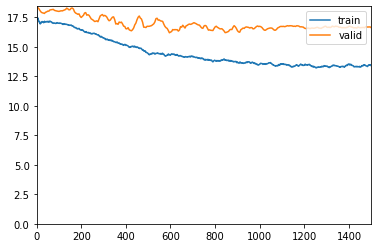

found new best at epoch 1
found new best at epoch 4
found new best at epoch 49
found new best at epoch 50
found new best at epoch 53
found new best at epoch 54
found new best at epoch 59
found new best at epoch 60
found new best at epoch 61
found new best at epoch 63
found new best at epoch 68
found new best at epoch 69
found new best at epoch 70
found new best at epoch 81
found new best at epoch 86
found new best at epoch 119
found new best at epoch 120
found new best at epoch 122
found new best at epoch 126
found new best at epoch 149
found new best at epoch 152


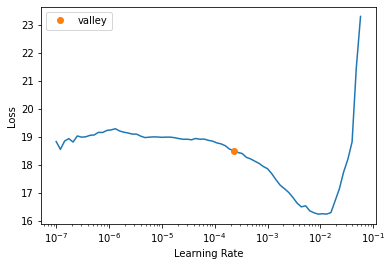

In [ ]:
# k-fold cross-validation training. Each training session uses its own dataloader with the defined validation column
bs=32 # smaller batch size to avoid memory limitations within colab.
all_preds=[]
all_targets=[]
smax = nn.Softmax(dim=0)
len_valid = [len(df[df[f'fold{i}_is_valid']==1]) for i in range(k)] # get the length of each fold's validation set. This is used in the callback to know where to write the best new results.

#k=1 # delete this line - needed to finish CV5 per the below
for i in range(k):

    # create current fold's datablock.
  bus = DataBlock(blocks=blocks,
                  getters=getters,
                  splitter=ColSplitter(col=f'fold4_is_valid'),
                  item_tfms=item_tfms,
                  batch_tfms=batch_tfms,
                  n_inp=1)
  dls = bus.dataloaders(df,bs=bs)

    # create model.
  net = MultiModel(backbone=densenet201(weights=DenseNet201_Weights.DEFAULT))
  
    # find initial best learning rate. 
  loss_func = MultiTaskLossWrapper(feature_weights=feature_weights,class_weights=class_weights,class_frequencies=class_frequencies,mixup = False)
  learn = Learner(dls, net, loss_func=loss_func, metrics=metrics)
  lr = learn.lr_find()

    # now perform the training using mixup.
  loss_func = MultiTaskLossWrapper(feature_weights=feature_weights,class_weights=class_weights,class_frequencies=class_frequencies,mixup = True) 
  learn = Learner(dls, net, loss_func=loss_func, metrics=metrics)

    # fit inital model heads. Then unfreeze and fit entire model
  learn.fit_one_cycle(10, lr.valley, cbs=[MultiMixHandler()])
  learn.unfreeze()
  learn.fit_one_cycle(300, lr_max = slice(lr.valley/400,lr.valley/4), cbs=[ShowGraphCallback(),MultiMixHandler(),SaveBestMetrics(fold=i, length=len_valid)])

In [ ]:
  # Code to use for creating the confusion matricies.
df_preds = pd.read_csv('/content/gdrive/MyDrive/BUS Project Home/Share_with_group/Josh_Jarvey/cv results/results_preds_densenet4.csv').T
df_targets = pd.read_csv('/content/gdrive/MyDrive/BUS Project Home/Share_with_group/Josh_Jarvey/cv results/results_targets_densenet4.csv').T

## JOIN file 3 with other file for the last fold.

for i in range(len(df_preds)):
    if i==5:continue
    else:
      y_pred=pd.Series(df_preds.iloc[i].to_list(), name = 'Predicted')
      y_true=pd.Series(df_targets.iloc[i].to_list(), name= 'Actual')

      cm = pd.crosstab( y_true,y_pred).reindex(fill_value=0)
      print(cm)
      print("\n")

Predicted  irregular  oval  round
Actual                           
irregular         51    31     32
oval              45    46     21
round              5     3      0


Predicted     not_parallel  parallel
Actual                              
not_parallel            38        52
parallel                62        82


Predicted          angular  circumscribed_  indistinct  microlobulated  none  \
Actual                                                                         
angular                  8               3           6               4     1   
circumscribed_          10              20          10              28    11   
indistinct               6               6           9              10     4   
microlobulated          13               9           6               7     3   
none                     0               1           1               1     0   
not_circumscribed        0               1           0               1     1   
spiculated               0            

In [ ]:
  # Calculate additional metrics using the Pathology as the feature of interest.
from sklearn.metrics import roc_auc_score, average_precision_score, f1_score, precision_score, recall_score, accuracy_score

y_pred=[0 if item=='Benign' else 1 for item in df_preds.iloc[6]]
y_target=[0 if item=='Benign' else 1 for item in df_targets.iloc[6]]

metric_funcs=[roc_auc_score,recall_score#i.e. sensitivity
              ,precision_score,f1_score, accuracy_score, average_precision_score]

for func in metric_funcs:
    print(func(y_target,y_pred))

0.5733904636343661
0.6422764227642277
0.5895522388059702
0.6147859922178989
0.5769230769230769
0.5666896910071282


In [ ]:
df_cv = pd.read_csv('/content/gdrive/MyDrive/BUS Project Home/Share_with_group/Josh_Jarvey/cv results/results_metrics_densenet4.csv'); df_cv

,epoch,train_loss,valid_loss,acc_shape,acc_orientation,acc_marginal_zone,acc_echo_pattern,acc_posterior_features,rmse_likelihood_of_malignancy,acc_pathology,combined_error,time
0,116,14.383977,15.387523,0.520833,0.708333,0.479167,0.104167,0.645833,0.359187,0.791667,3.109187,0:08
1,199,13.829735,16.350832,0.652174,0.869565,0.391304,0.239130,0.630435,0.291613,0.652174,2.856831,"0 00:08\nName: time, dtype: object"
2,286,13.522098,16.242622,0.617021,0.851064,0.425532,0.255319,0.574468,0.307332,0.808511,2.775417,"0 00:07\nName: time, dtype: object"
3,156,13.535676,16.509018,0.702128,0.872340,0.404255,0.297872,0.595745,0.255145,0.638298,2.744507,"0 00:08\nName: time, dtype: object"
4,152,13.913844,16.601072,0.695652,0.608696,0.369565,0.326087,0.565217,0.251295,0.695652,2.990425,0:07


In [ ]:
print(df_cv.mean())

epoch                            181.800000
train_loss                        13.837066
valid_loss                        16.218213
acc_shape                          0.637562
acc_orientation                    0.782000
acc_marginal_zone                  0.413965
acc_echo_pattern                   0.244515
acc_posterior_features             0.602340
rmse_likelihood_of_malignancy      0.292914
acc_pathology                      0.717260
combined_error                     2.895273
dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.
  """Entry point for launching an IPython kernel.


In [ ]:
import matplotlib.pyplot as plt
pd.set_option('expand_frame_repr', False)

  # return predictions and targets from the validation set.
preds, targets = learn.get_preds()

smax = nn.Softmax(dim=0)

for i, feature in enumerate(['shape_acr','orientation','marginal_zone_acr','echo_pattern_acr','posterior_features_acr','pathology']):
      # for each prediction output apply a softmax. Then apply argmax to get the class with the highest value. Get the actual value with .item(), then wrap it into a list and then pandas series for the cm.
    y_pred = pd.Series(dls.vocab[i][[torch.argmax(smax(pred)).item() for pred in preds[i]]], name='Predicted')
    
      # change the tensor of actual values into a list. Wrap in pandas series for the cm.
    y_true = pd.Series(dls.vocab[i][targets[i].tolist()], name='Actual')

      # create the crosstab with the actual data. Then reindex the crosstab using the full label set for this feature - fill any missing values with a zero.
    cm = pd.crosstab(y_true, y_pred).reindex(index=dls.vocab[i], columns=dls.vocab[i],fill_value=0)

      # need to skip over regression results by i+1.
    if feature == 'pathology':
      y_pred = pd.Series(dls.vocab[i][[torch.argmax(smax(pred)).item() for pred in preds[i+1]]], name='Predicted')
      y_true = pd.Series(dls.vocab[i][targets[i+1].tolist()], name='Actual')
      cm = pd.crosstab(y_true, y_pred).reindex(index=dls.vocab[i], columns=dls.vocab[i],fill_value=0)

    fig=plt.figure()
    plt.imshow(cm, interpolation='nearest', cmap="Blues")  
    plt.title(f"Confusion Matrix for {feature}")
    tick_marks = np.arange(len(dls.vocab[i]))
    plt.xticks(tick_marks, dls.vocab[i], rotation=90)
    plt.yticks(tick_marks, dls.vocab[i], rotation=0)

    thresh = cm.values.max()/2
    for j, k in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
      coeff=f'{cm.iloc[j,k]}'
      plt.text(k, j, coeff, horizontalalignment="center", verticalalignment="center", color="white" if cm.iloc[j,k] > thresh else "black")

    ax = fig.gca()
    ax.set_ylim(len(dls.vocab[i])-.5,-.5)
    plt.tight_layout()
    plt.ylabel('Actual')
    plt.xlabel('Predicted')
    plt.grid(False)